In [2]:
import os
from itertools import count
import random
import collections
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import gym
import rl_utils

os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"


In [3]:
class Qnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim) -> None:
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class DQN:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, 
            gamma, eps, target_update, device) -> None:
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.eps = eps
        self.target_update = target_update
        self.count = 0
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.eps:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards= torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        
        q_values = self.q_net(states).gather(1, actions)
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1-dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1

c:\ProgramData\Anaconda3\lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
c:\ProgramData\Anaconda3\lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\ProgramData\Anaconda3\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\ProgramData\Anaconda3\lib\site-packages\gym\core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(s

state_dim: 4, hidden_dim: 128, action_dim: 2


Iteration 9: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, episode=500.0, return=189.700]


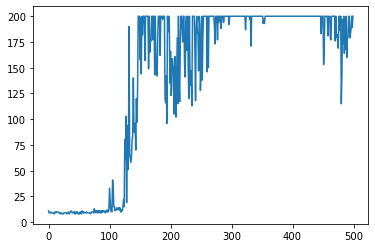

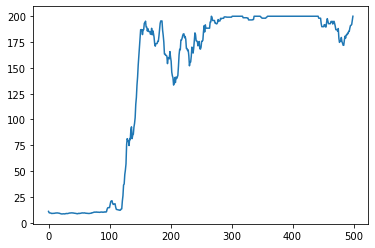

In [6]:
from rl_utils import ReplayBuffer


lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
eps = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

env_name = 'CartPole-v0'
env = gym.make(env_name)
random.seed(0)
# env.seed(seed=0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print(f'state_dim: {state_dim}, hidden_dim: {hidden_dim}, action_dim: {action_dim}')
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, eps, target_update, device)

return_list = []
@rl_utils.run_episodes(num_episodes, return_list)
def run_dqn():
    episode_return = 0
    state = env.reset(seed=0)
    done = False
    while not done:
        action = agent.take_action(state)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state
        episode_return += reward
        if replay_buffer.size() > minimal_size:
            b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
            transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
            agent.update(transition_dict)
    return episode_return

run_dqn()


episode_list = list(range(len(return_list)))
plt.plot(episode_list, return_list)
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episode_list, mv_return)
plt.show()